In [1]:
import copy
import argparse
import glob
import itertools
import math
import os
import random
import sys

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML, clear_output
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchmetrics import StructuralSimilarityIndexMeasure
from torchvision.models import vgg19
from torchvision.utils import make_grid, save_image
from tqdm import tqdm as tqdm

random.seed(42)
import warnings

warnings.filterwarnings("ignore")
from torchvision.models.vgg import vgg16

# Data Preparation

In [2]:
n_epochs = 10
dataset_path = "/kaggle/input/ml4sci/sr_resolution/Dataset"
batch_size = 8
lr = 0.001
channels = 1
scale_factor = 2
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

In [3]:
class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        self.lr_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
        self.hr_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
        self.files = files
    
    def __getitem__(self, index):
        img0 = np.load(self.files[index % len(self.files)][0], allow_pickle=True)[0]
        img1 = np.load(self.files[index % len(self.files)][1], allow_pickle=True)[0]
        img0  = img0.astype('float32')
        img1  = img1.astype('float32')
        img_lr = self.lr_transform(img0)
        img_hr = self.hr_transform(img1)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [4]:
HR, LR = sorted(glob.glob(dataset_path + "/HR/*")), sorted(glob.glob(dataset_path + "/LR/*"))
paths = []
for i in range(len(HR)): paths.append([LR[i], HR[i]])
train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42) 
train_loader = DataLoader(ImageDataset(train_paths, hr_shape=(150, 150)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ImageDataset(test_paths, hr_shape=(150, 150)), batch_size=int(batch_size*0.75), shuffle=True)

In [5]:
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Metrics

In [6]:
ssim = StructuralSimilarityIndexMeasure().to(device)
epoch_psnr = AverageMeter()
ssim_scores = AverageMeter()
mse = AverageMeter()
for i in tqdm(test_loader):
    hr = transforms.Resize(150)(i['lr'].to(device))
    ssim_scores.update(ssim(hr, i['hr'].to(device)), len(i['hr']))
    epoch_psnr.update(calc_psnr(hr, i['hr'].to(device)), len(i['hr']))
    mse.update(nn.MSELoss()(hr, i['hr'].to(device)), len(i['hr']))
print('SSIM:',ssim_scores.avg.item())
print('PSNR:', epoch_psnr.avg.item())
print('MSE: %f'% mse.avg.item())

100%|██████████| 167/167 [00:16<00:00, 10.09it/s]

SSIM: 0.9720772504806519
PSNR: 41.626407623291016
MSE: 0.000069


# Visualization

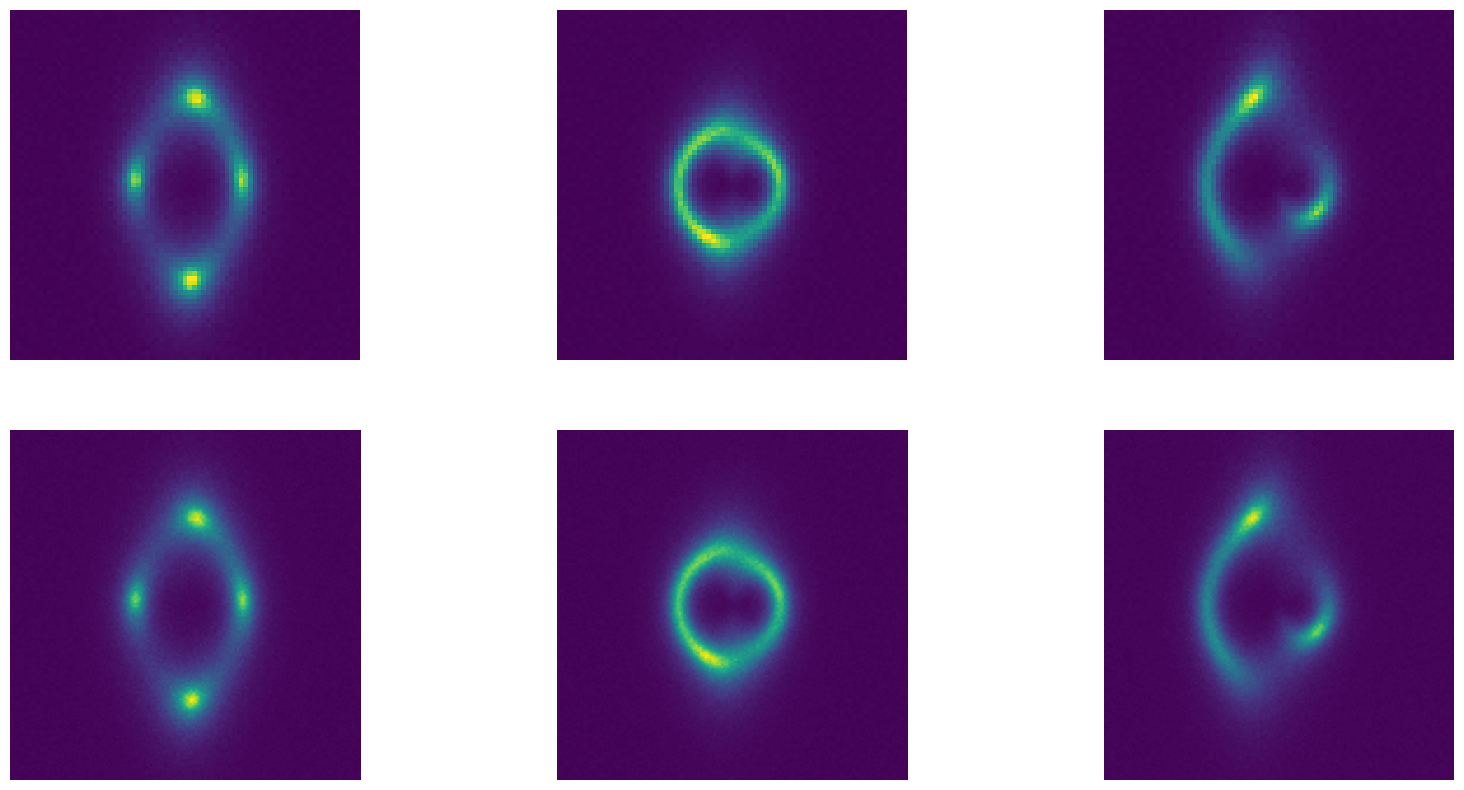

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
images = next(iter(test_loader))

# Plot the low resolution images
for i in range(3):
    axs[0, i].imshow(np.load(train_paths[i][0]).transpose(2,1,0),)
    axs[0, i].axis('off')

# Plot the high resolution images
for i in range(3):
    axs[1, i].imshow(np.load(train_paths[i][1]).transpose(2,1,0),)
    axs[1, i].axis('off')

# Model

In [8]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor=2, num_channels=1, d=64, s=12, m=4):
        super(FSRCNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=5//2),
            nn.PReLU(d)
        )
        self.mid_part = [nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s)]
        for _ in range(m):
            self.mid_part.extend([nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s)])
        self.mid_part.extend([nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d)])
        self.mid_part = nn.Sequential(*self.mid_part)
        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=scale_factor, padding=9//2,
                                            output_padding=scale_factor-1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.first_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.mid_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        nn.init.normal_(self.last_part.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.last_part.bias.data)

    def forward(self, x):
        x1 = self.first_part(x)
        x2 = self.mid_part(x1)
        x3 = self.last_part(x2)
        return x3

In [9]:
model = FSRCNN(scale_factor=2).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training

In [10]:
best_weights = copy.deepcopy(model.state_dict())
best_epoch = 0
best_psnr = 0.0

for epoch in range(1,1+n_epochs):
    model.train()
    epoch_losses = AverageMeter()

    with tqdm(total=(len(train_paths) - len(train_paths) % 16)) as t:
        t.set_description('epoch: {}/{}'.format(epoch, n_epochs))

        for data in train_loader:
            inputs, labels = data['lr'], data['hr']

            inputs = inputs.to(device)
            labels = labels.to(device)

            preds = model(inputs)
            loss = criterion(preds, labels)

            epoch_losses.update(loss.item(), len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))
            t.update(len(inputs))
    scheduler.step()

    model.eval()
    epoch_psnr = AverageMeter()
    ssim = StructuralSimilarityIndexMeasure().to(device)
    ssim_scores = []
    for data in tqdm(test_loader):
        inputs, labels = data['lr'], data['hr']

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            preds = model(inputs).clamp(0.0, 1.0)
        ssim_score = ssim(labels.cpu(), preds.cpu())
        ssim_scores.append(ssim_score.item())
        epoch_psnr.update(calc_psnr(preds, labels), len(inputs))
    print(f'ssim: {np.array(ssim_scores).mean()}')
    print('eval psnr: {:.2f}'.format(epoch_psnr.avg))

    if epoch_psnr.avg > best_psnr:
        best_epoch = epoch
        best_psnr = epoch_psnr.avg
        best_weights = copy.deepcopy(model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, 'fsrcnn.pth')

epoch: 1/10: : 9000it [02:10, 68.95it/s, loss=0.000157]
100%|██████████| 167/167 [00:13<00:00, 12.82it/s]


ssim: 0.9689417224444316
eval psnr: 41.09


epoch: 2/10: : 9000it [00:26, 334.41it/s, loss=0.000068]
100%|██████████| 167/167 [00:12<00:00, 13.68it/s]


ssim: 0.9737169075154972
eval psnr: 42.13


epoch: 3/10: : 9000it [00:27, 328.98it/s, loss=0.000063]                        
100%|██████████| 167/167 [00:12<00:00, 13.47it/s]


ssim: 0.9740662817469614
eval psnr: 42.09


epoch: 4/10: : 9000it [00:28, 310.76it/s, loss=0.000060]
100%|██████████| 167/167 [00:12<00:00, 12.98it/s]


ssim: 0.9741176734427492
eval psnr: 42.23


epoch: 5/10: : 9000it [00:30, 299.37it/s, loss=0.000060]                        
100%|██████████| 167/167 [00:12<00:00, 12.95it/s]


ssim: 0.9741679090939596
eval psnr: 42.24


epoch: 6/10: : 9000it [00:31, 285.18it/s, loss=0.000060]                        
100%|██████████| 167/167 [00:12<00:00, 13.57it/s]


ssim: 0.9742171564501917
eval psnr: 42.25


epoch: 7/10: : 9000it [00:28, 321.00it/s, loss=0.000059]                        
100%|██████████| 167/167 [00:12<00:00, 13.05it/s]


ssim: 0.9742265675596135
eval psnr: 42.25


epoch: 8/10: : 9000it [00:27, 329.14it/s, loss=0.000059]                        
100%|██████████| 167/167 [00:12<00:00, 13.36it/s]


ssim: 0.9742371975304838
eval psnr: 42.25


epoch: 9/10: : 9000it [00:27, 333.03it/s, loss=0.000059]                        
100%|██████████| 167/167 [00:12<00:00, 13.24it/s]


ssim: 0.9742496581134682
eval psnr: 42.26


epoch: 10/10: : 9000it [00:27, 328.03it/s, loss=0.000059]
100%|██████████| 167/167 [00:12<00:00, 13.68it/s]

ssim: 0.9742414241065522
eval psnr: 42.26
best epoch: 10, psnr: 42.26


In [11]:
model.load_state_dict(torch.load('fsrcnn.pth'))

<All keys matched successfully>

# Results

In [12]:
ssim = StructuralSimilarityIndexMeasure().to(device)
epoch_psnr = AverageMeter()
ssim_scores = AverageMeter()
mse = AverageMeter()
for i in tqdm(test_loader):
    torch.cuda.empty_cache()
    hr = model(i['lr'].to(device))
    ssim_scores.update(ssim(hr, i['hr'].to(device)), len(i['hr']))
    epoch_psnr.update(calc_psnr(hr, i['hr'].to(device)), len(i['hr']))
    mse.update(criterion(hr, i['hr'].to(device)), len(i['hr']))
print('SSIM:',ssim_scores.avg.item())
print('PSNR:', epoch_psnr.avg.item())
print('MSE: %f'% mse.avg.item())

100%|██████████| 167/167 [00:03<00:00, 53.81it/s]

SSIM: 0.9742863178253174
PSNR: 42.2563591003418
MSE: 0.000060


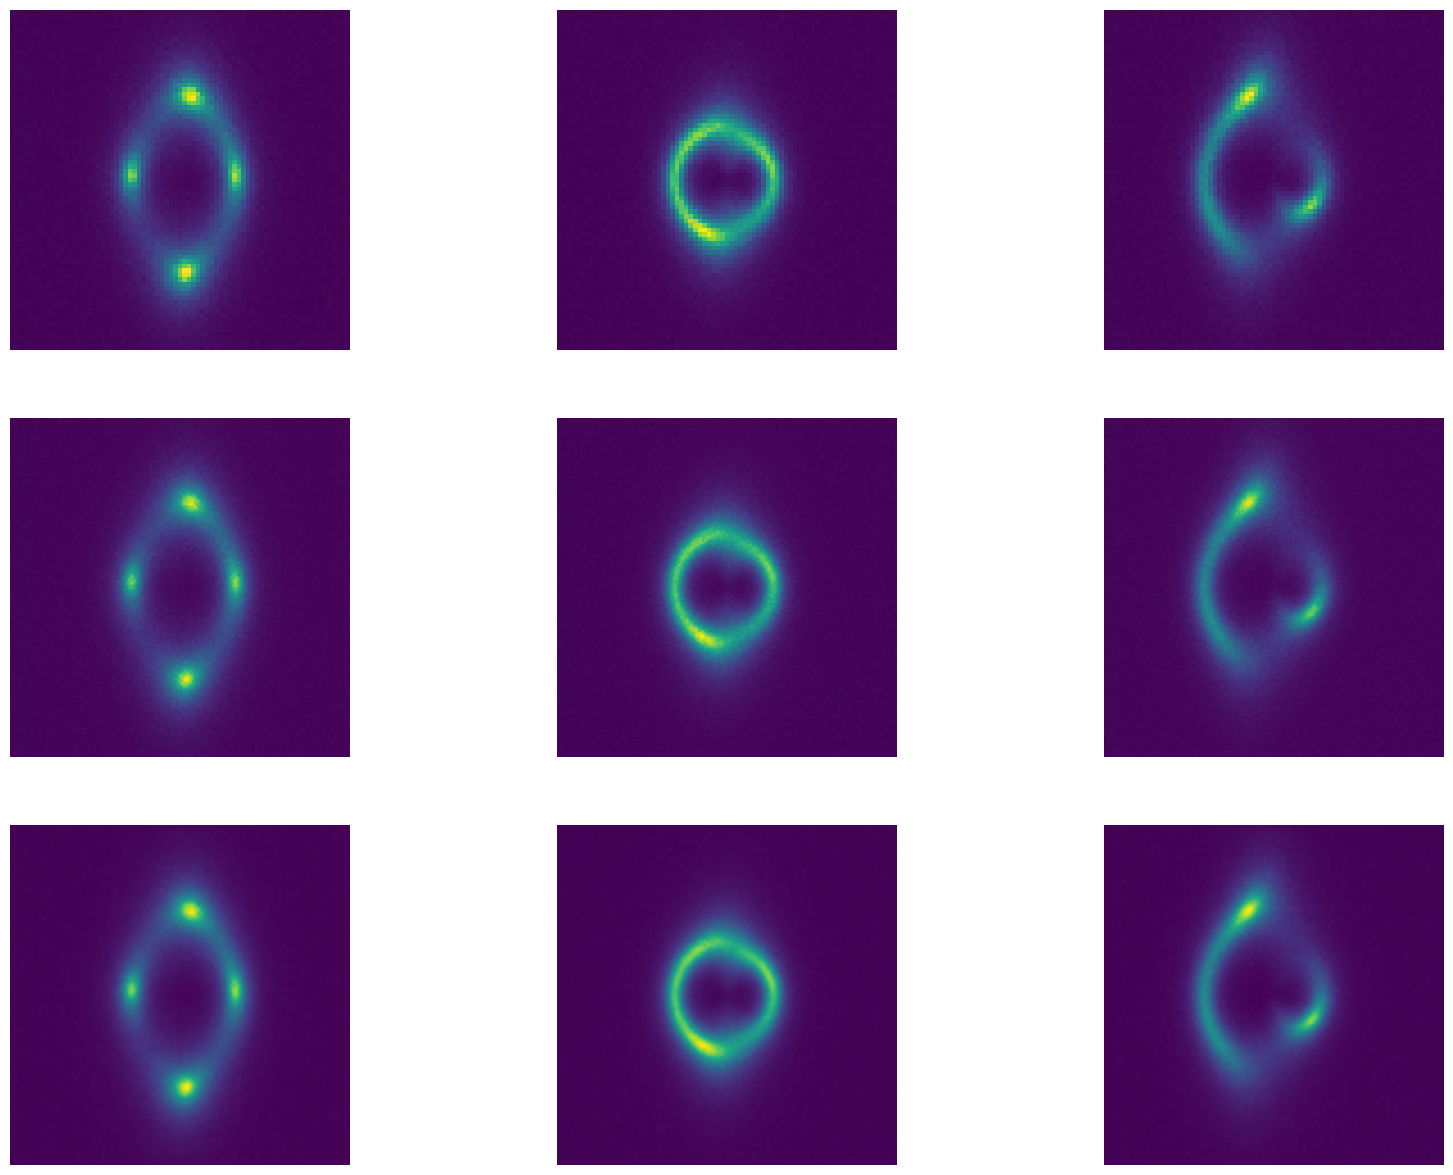

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))


# Plot the low resolution images
for i in range(3):
    axs[0, i].imshow(np.load(train_paths[i][0]).transpose(2,1,0),)
    axs[0, i].axis('off')

# Plot the high resolution images
for i in range(3):
    axs[1, i].imshow(np.load(train_paths[i][1]).transpose(2,1,0),)
    axs[1, i].axis('off')
    
# Plot the predicted images
img = torch.tensor([
    np.load(train_paths[0][0]),
    np.load(train_paths[1][0]),
    np.load(train_paths[2][0])
]).float()
pred_images = model(img.cuda()).detach().cpu()
for i in range(3):
    axs[2, i].imshow(pred_images[i].permute(2,1,0))
    axs[2, i].axis('off')